In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display

In [3]:
from os.path import join, dirname, exists
from os import makedirs

from thesis_v2 import dir_dict
import pandas as pd


f_main_result = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200725', 'main_result.pkl')

In [4]:
df_main_result = pd.read_pickle(f_main_result)

In [5]:
df_main_result

cc2_normed_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                   
relu     True                 mse       0          2         8           1           cm-avg       1280              0.380000   
         False                mse       0          2         8           1           cm-avg       1280              0.357125   
         True                 mse       0          2         8           2           cm-avg       1280              0.400852   
         False                mse       0          2         8           2           cm-avg       1280              0.390532   
         True                 mse       0          2         8           3           cm-avg       1280              0.397727   
...                                                                                                                      ...   
softplus False                poisson   1          4         32          1           legacy       5120              0.666608   
         True                 poisson   1          5         32          1           legacy       5120              0.671754   
         False                poisson   1          5         32          1           legacy       5120              0.669742   
         True                 poisson   1          6         32          1           legacy       5120              0.674378   
         False                poisson   1          6         32          1           legacy       5120              0.676021   

                                                                                                              cc2_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                
relu     True                 mse       0          2         8           1           cm-avg       1280           0.182549   
         False                mse       0          2         8           1           cm-avg       1280           0.170239   
         True                 mse       0          2         8           2           cm-avg       1280           0.190568   
         False                mse       0          2         8           2           cm-avg       1280           0.187182   
         True                 mse       0          2         8           3           cm-avg       1280           0.188654   
...                                                                                                                   ...   
softplus False                poisson   1          4         32          1           legacy       5120           0.306528   
         True                 poisson   1          5         32          1           legacy       5120           0.308807   
         False                poisson   1          5         32          1           legacy       5120           0.307882   
         True                 poisson   1          6         32          1           legacy       5120           0.310332   
         False                poisson   1          6         32          1           legacy       5120           0.310975   

                                                                                                              cc_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep               
relu     True                 mse       0          2         8           1           cm-avg       1280          0.389889   
         False                mse       0          2         8           1           cm-avg       1280          0.379368   
         True                 mse       0          2         8           2           cm-avg       1280          0.404994   
         False                mse       0          2         8           2           cm-avg       1280          0.398958   
         True                 mse       0          2         8           3 

In [6]:
# iterate over three metrics. cc2_normed, cc2_raw, cc_raw.

# iterate over each train_size.

# plot

def main_loop(df_in):
    for metric in ('cc2_normed_avg', 'cc2_raw_avg', 'cc_raw_avg'):
        print(metric)
        df_this = df_in.loc[:,[metric, 'num_param']].rename(columns={metric: 'perf'})
        loop_over_train_size(df_this)

def loop_over_train_size(df_in):
    for train_keep in df_in.index.get_level_values('train_keep').unique():
        print(train_keep)
        df_this = df_in.xs(train_keep, level='train_keep').sort_index()
        process_one_case(df_this)

In [7]:
from scipy.stats import pearsonr
import numpy as np

In [8]:
def check_model_seeds(df_in):
    assert set(df_in.index.get_level_values('model_seed').unique()) == {0,1}
    data_0 = df_in['perf'].xs(0, level='model_seed').sort_index()
    data_1 = df_in['perf'].xs(1, level='model_seed').sort_index()
    assert data_0.index.equals(data_1.index)
    data_0_raw = data_0.values
    data_1_raw = data_1.values
    
    print(f'seed=0, mean {data_0_raw.mean()} std {data_0_raw.std()}')
    print(f'seed=1, mean {data_1_raw.mean()} std {data_1_raw.std()}')
    print('corr', pearsonr(data_0_raw, data_1_raw)[0])
    
    
    # check that num_param are the same.
    data_0_num_param = df_in['num_param'].xs(0, level='model_seed').sort_index()
    data_1_num_param = df_in['num_param'].xs(1, level='model_seed').sort_index()
    assert data_0_num_param.equals(data_1_num_param)

def avg_out_seed(df_in):
    df_perf = df_in['perf'].unstack('model_seed').mean(axis=1).sort_index()
    df_num_param = df_in['num_param'].xs(0, level='model_seed').sort_index()
    df_perf.name = 'perf'
    df_num_param.name = 'num_param'
    assert df_perf.index.equals(df_num_param.index)
    ret = pd.concat([df_perf, df_num_param], axis='columns')
    assert ret.index.equals(df_perf.index)
    assert ret.index.equals(df_num_param.index)
    return ret

def process_ff_models(df_in):
    # for each combination of (num_channel, num_layer)
    # generate a sub data frame
    # indexed by ('act_fn', 'ff_1st_bn_before_act', 'loss_type')
    # with columns (perf, num_param)
    
    data = df_in.xs(1, level='rcnn_bl_cls', drop_level=False)
    
#     index_names = data.index.name
    
    index_out_channel = data.index.get_level_values('out_channel').values
    index_num_layer = data.index.get_level_values('num_layer').values
    
    data_channel_layer = np.asarray([index_out_channel, index_num_layer]).T
#     print(data_channel_layer.dtype, data_channel_layer.shape)
    unique_channel_layer = np.unique(data_channel_layer, axis=0).tolist()
    
    
    data_dict = dict()
    
    for key_this in unique_channel_layer:
        key_this = tuple(key_this)
        (c_this, l_this) = key_this
        df_this = data.xs(key=(c_this, l_this), level=('out_channel', 'num_layer'))
#         print(df_this.shape)
        # average out over readout_type
        df_this = df_this.unstack('readout_type')
        perf = df_this['perf']
        num_param = df_this['num_param']
        assert perf.shape == num_param.shape
        num_readout = perf.shape[1]
        # take average to remove card-to-card variance.
        # remove NAs due to incomplete configs.
        perf = perf.mean(axis=1, skipna=True)
        for _, row_this in num_param.iterrows():
            assert row_this.nunique(dropna=True) == 1

        num_param = num_param.mean(axis=1, skipna=True)
        assert perf.index.equals(num_param.index)
        
        perf.name = 'perf'
        num_param.name = 'num_param'
#         print(perf.name, num_param.name)
        ret = pd.concat([perf, num_param], axis='columns')
#         print(ret.columns)
#         assert ret.columns == ['perf', 'num_param']
        assert ret.index.equals(perf.index)
        assert ret.index.equals(num_param.index)
        
        data_dict[key_this] = ret
    return data_dict

def process_recurrent_models(df_in, readout_type):
    data = df_in.xs(readout_type, level='readout_type')
    data = data.iloc[data.index.get_level_values('rcnn_bl_cls') != 1]
    print(data.shape)
        
    
    index_out_channel = data.index.get_level_values('out_channel').values
    index_num_layer = data.index.get_level_values('num_layer').values
    
    data_channel_layer = np.asarray([index_out_channel, index_num_layer]).T
#     print(data_channel_layer.dtype, data_channel_layer.shape)
    unique_channel_layer = np.unique(data_channel_layer, axis=0).tolist()
    
    
        
    data_dict = dict()
    
    for key_this in unique_channel_layer:
        key_this = tuple(key_this)
        (c_this, l_this) = key_this
        df_this = data.xs(key=(c_this, l_this), level=('out_channel', 'num_layer'))
#         print(df_this.shape)
        # average out over readout_type
        data_dict[key_this] = df_this
    return data_dict

        
        
        
    
    
#     assert data.shape[1] == 3
    
#     print()
    
#     for idx, case in data.iterrows():
#         case_val = case.values
#         assert case_val.shape == (3,)
        # get non nan values
#         case_non_nan = case_val[~np.isnan(case)]
#         assert case_non_nan.size > 0
#         case_non_nan_debug = np.full_like(case_non_nan, fill_value=case_non_nan[0])
#         if not np.allclose(case_non_nan, case_non_nan_debug, atol=1e-3):
#             print(idx, case)
#             print(case_non_nan, case_non_nan_debug)
#         assert np.allclose(case_non_nan, case_non_nan_debug, atol=1e-3)

# actually, probably due to card-to-card variance, difference can appear.
# I checked one of them.

# 5120, cc_mean_avg
# (relu, False, poisson, 2, 32)
# cm-avg     0.499929
# cm-last    0.496784
# legacy          NaN
# Name: (relu, False, poisson, 2, 32), dtype: float64
# [0.49992943 0.49678396] [0.49992943 0.49992943]

# for cm-avg
# check files
# models/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/
# s_selegacy/in_sz50/out_ch32/num_l2/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c1/r_psize1/r_ptypeNone/
# r_acccummean/ff1st_True/ff1stbba_False/rp_none/sc0.01/sm0.000005/lpoisson/m_se0/stats_best.json
#
# corr_mean: 0.5004660408667474
# "best_phase": 2, "best_epoch": 50, "early_stopping_loss": 0.813396155834198
# 
# and
#
# models/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/
# s_selegacy/in_sz50/out_ch32/num_l2/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c1/r_psize1/r_ptypeNone/
# r_acccummean/ff1st_True/ff1stbba_False/rp_none/sc0.01/sm0.000005/lpoisson/m_se1/stats_best.json
#
# corr_mean: 0.49939281448219086
# "best_phase": 1, "best_epoch": 1150, "early_stopping_loss": 0.8130963444709778


# for cm-last
# check files
# .... r_acccummean_last/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0/stats_best.json
# 
# "corr_mean": 0.49417510516371543
# "best_phase": 2, "best_epoch": 150, "early_stopping_loss": 0.8139971494674683
#
# and
#
# .... r_acccummean_last/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1/stats_best.json
#
# corr_mean: 0.49939281448219086
# {"best_phase": 1, "best_epoch": 1150, "early_stopping_loss": 0.8130963444709778


# in this case, when seed=1, results are same; when seed=0, they are different.


def process_one_case(df_in):
    print(df_in.shape)
    # for each metric.


    # 1. compare seed=0 and seed=1. make sure things are ok.
    # the larger the training size is, the more stable across seeds.
    check_model_seeds(df_in)
    
    # 2. take average of model seeds.
    df_in = avg_out_seed(df_in)
    print(df_in.shape)
    

    # 3. for each combination (ff, PROPER cm-avg x num_layer, PROPER cm-last x num_layer) x (out_channel, num_layer)
    #    compute average. make sure each one has SAME number of settings (handle cm-avg/cm-last ambiguity for ff)
    data_ff = process_ff_models(df_in)
    data_r_cm_avg = process_recurrent_models(df_in, 'cm-avg')
    data_r_cm_last = process_recurrent_models(df_in, 'cm-last')
    recurrent_setups = data_r_cm_avg.keys()
    assert recurrent_setups == data_r_cm_avg.keys() == data_r_cm_last.keys()
    
    # 4. create a mapping between ff (out, num_layer) to similarly sized PROPER recurrents.
    recurrent_to_ff_setup_mapping = dict()
    for setup_r in recurrent_setups:
        recurrent_to_ff_setup_mapping[setup_r] = (setup_r[0], (setup_r[1]-1)*2 + 1)
        # we have matching ff models of similar parameters
        assert recurrent_to_ff_setup_mapping[setup_r] in data_ff
#     print(recurrent_to_ff_setup_mapping)

    # 5. plot/table! maybe have both combined / separate results.

    # KEEP number of parameters the same, so that things are comparable.
    plot_one_case(data_ff=data_ff, data_r=data_r_cm_avg, r_name='cm-avg',
                 recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping)
    
    
    plot_one_case(data_ff=data_ff, data_r=data_r_cm_last, r_name='cm-last',
                 recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping)
    
    # 

    
def plot_one_case(
    *,
    data_ff,
    data_r,
    r_name,
    recurrent_to_ff_setup_mapping,
):
    # 1 for everything
    num_setup = len(data_r) + 1
    nrows = (num_setup-1)//2+1
    ncols = 2
    
    plt.close('all')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10/ncols*nrows+1), squeeze=False)
    fig.suptitle(f'{r_name}')
    axes = axes.ravel()
    for idx, setup_this in enumerate(data_r):
        ax = axes[idx]
        setup_this_ff = recurrent_to_ff_setup_mapping[setup_this]
        plot_one_case_inner(
            ax = ax,
            data_ff = data_ff[setup_this_ff],
            data_r = data_r[setup_this],
            setup_ff = setup_this_ff,
            setup_r = setup_this,
            print_params = True,
        )
    
    plt.show()

def plot_one_case_inner(
    *,
    ax,
    data_ff,
    data_r,
    setup_ff,
    setup_r,
    print_params,
):
    assert len(setup_ff) == len(setup_r) == 2
    assert setup_ff[0] == setup_r[0]
    num_c = setup_ff[0]
    num_l_ff = setup_ff[1]
    num_l_r = setup_r[1]
    
    ax.set_title(f'{num_c} channels, {num_l_ff} CPBs vs. (1 CPB + {num_l_r-1} RCPBs)')
    
#     print(data_r.columns)
#     print(data_ff.columns)
    
    perf_ff = data_ff['perf']
    num_param_ff = data_ff['num_param']
    
    perf_r = data_r['perf']
    num_param_r = data_r['num_param']
    
    num_param = pd.concat([num_param_ff, num_param_r],axis=0).sort_index().unstack('rcnn_bl_cls').sort_index()
    perf = pd.concat([perf_ff, perf_r],axis=0).sort_index().unstack('rcnn_bl_cls').sort_index()
    
    display(num_param.mean(axis=0).to_frame().T)
#     display(perf)
    assert np.all(np.isfinite(num_param.values))
    assert np.all(np.isfinite(perf.values))
    
    
    perf_mean = perf.mean(axis=0)
    perf_sem = perf.std(axis=0,ddof=0)/perf.shape[0]
    perf_min = perf_mean.min()
    perf_max = perf_mean.max()
    margin = (perf_max-perf_min)*0.05
#     perf = perf.mean(axis=0)
    
#     print(num_param)
#     print(perf)

    perf_mean.plot(ax=ax, kind='bar', yerr=perf_sem, ylim=(perf_min-margin,perf_max+margin))

cc2_normed_avg
1280
(1872, 2)
seed=0, mean 0.4665990525514411 std 0.07990275148459684
seed=1, mean 0.4688627050028689 std 0.0783478402817805
corr 0.919645772049287
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


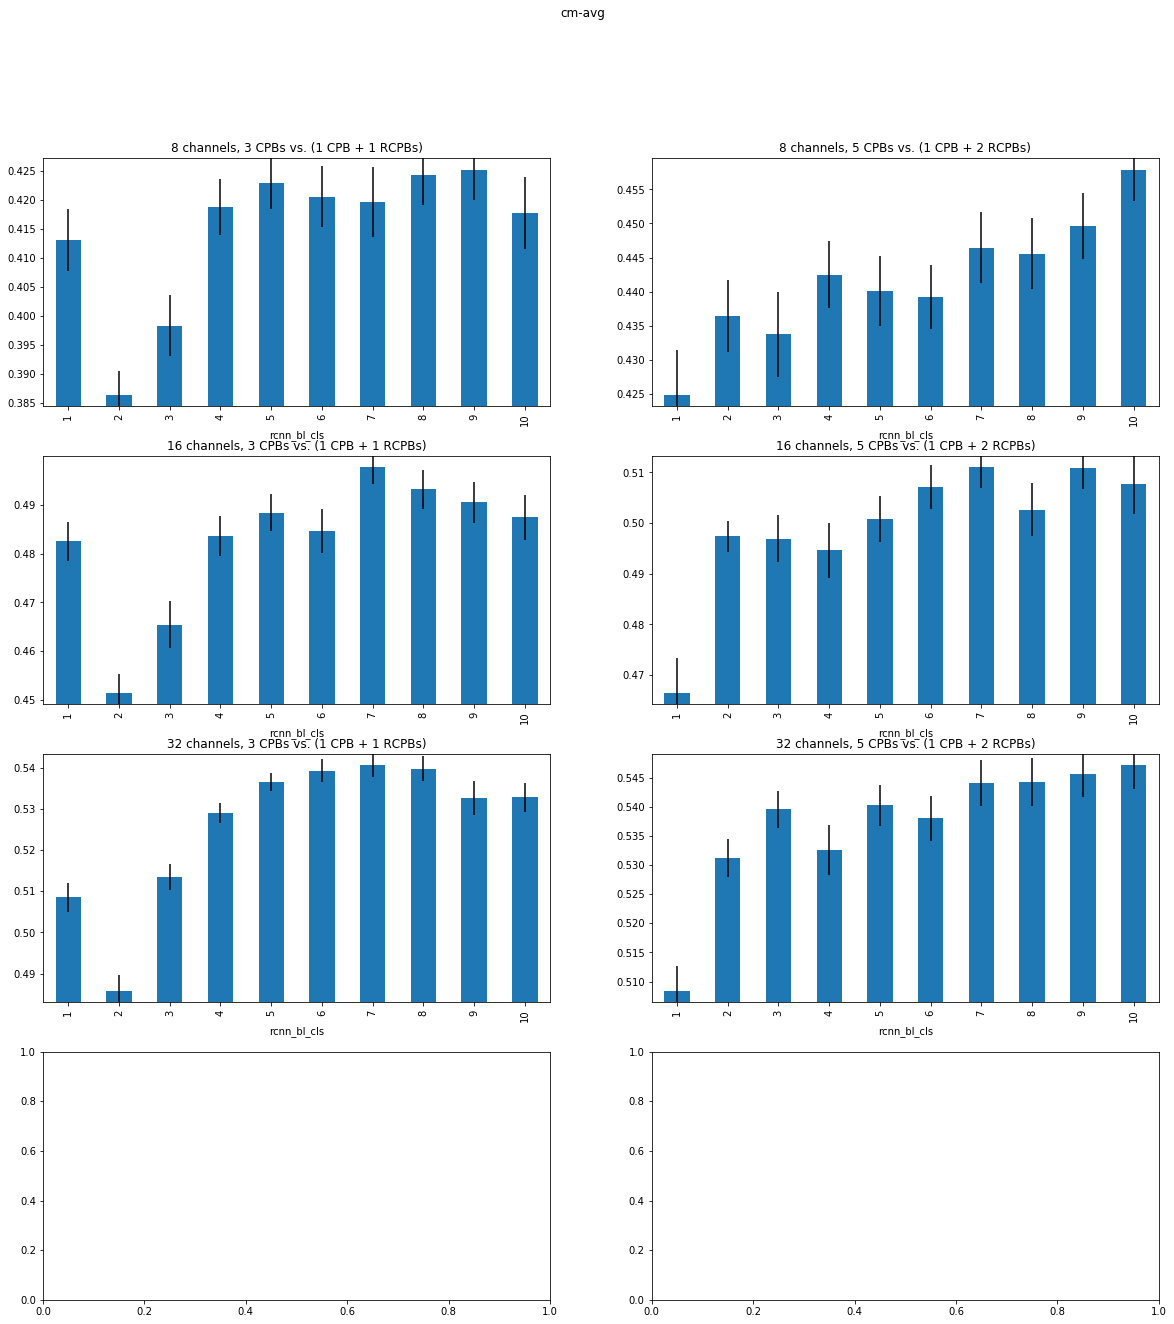

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


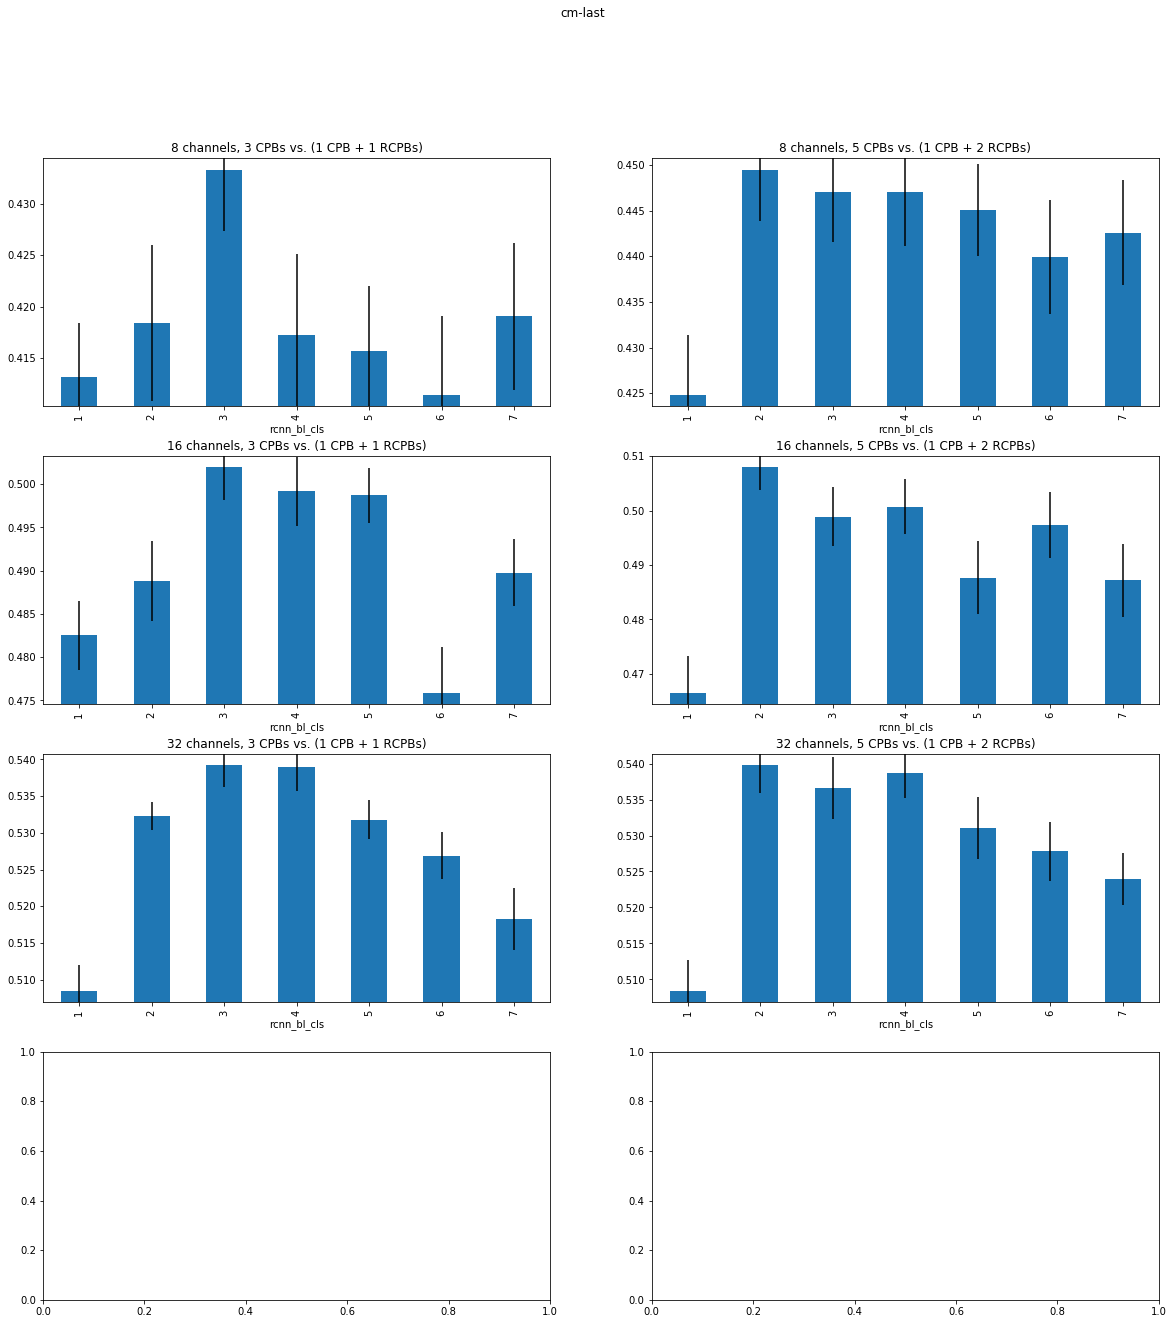

2560
(1872, 2)
seed=0, mean 0.5758502908285674 std 0.05274786024254501
seed=1, mean 0.5755912712916434 std 0.05441454150695219
corr 0.957336951512258
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


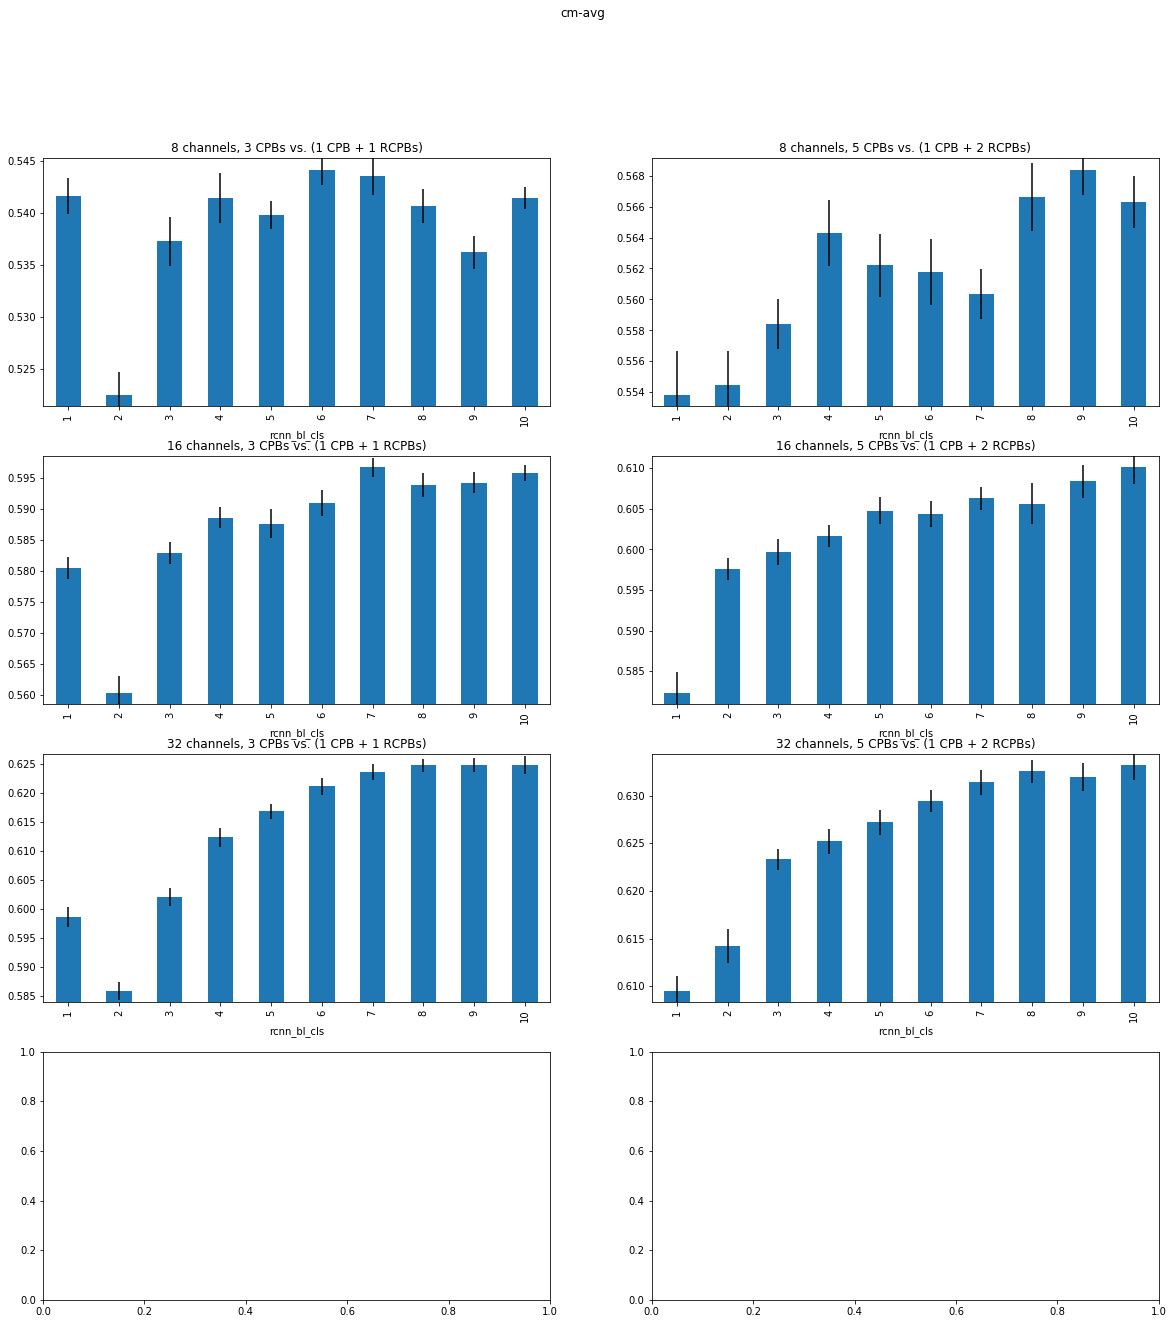

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


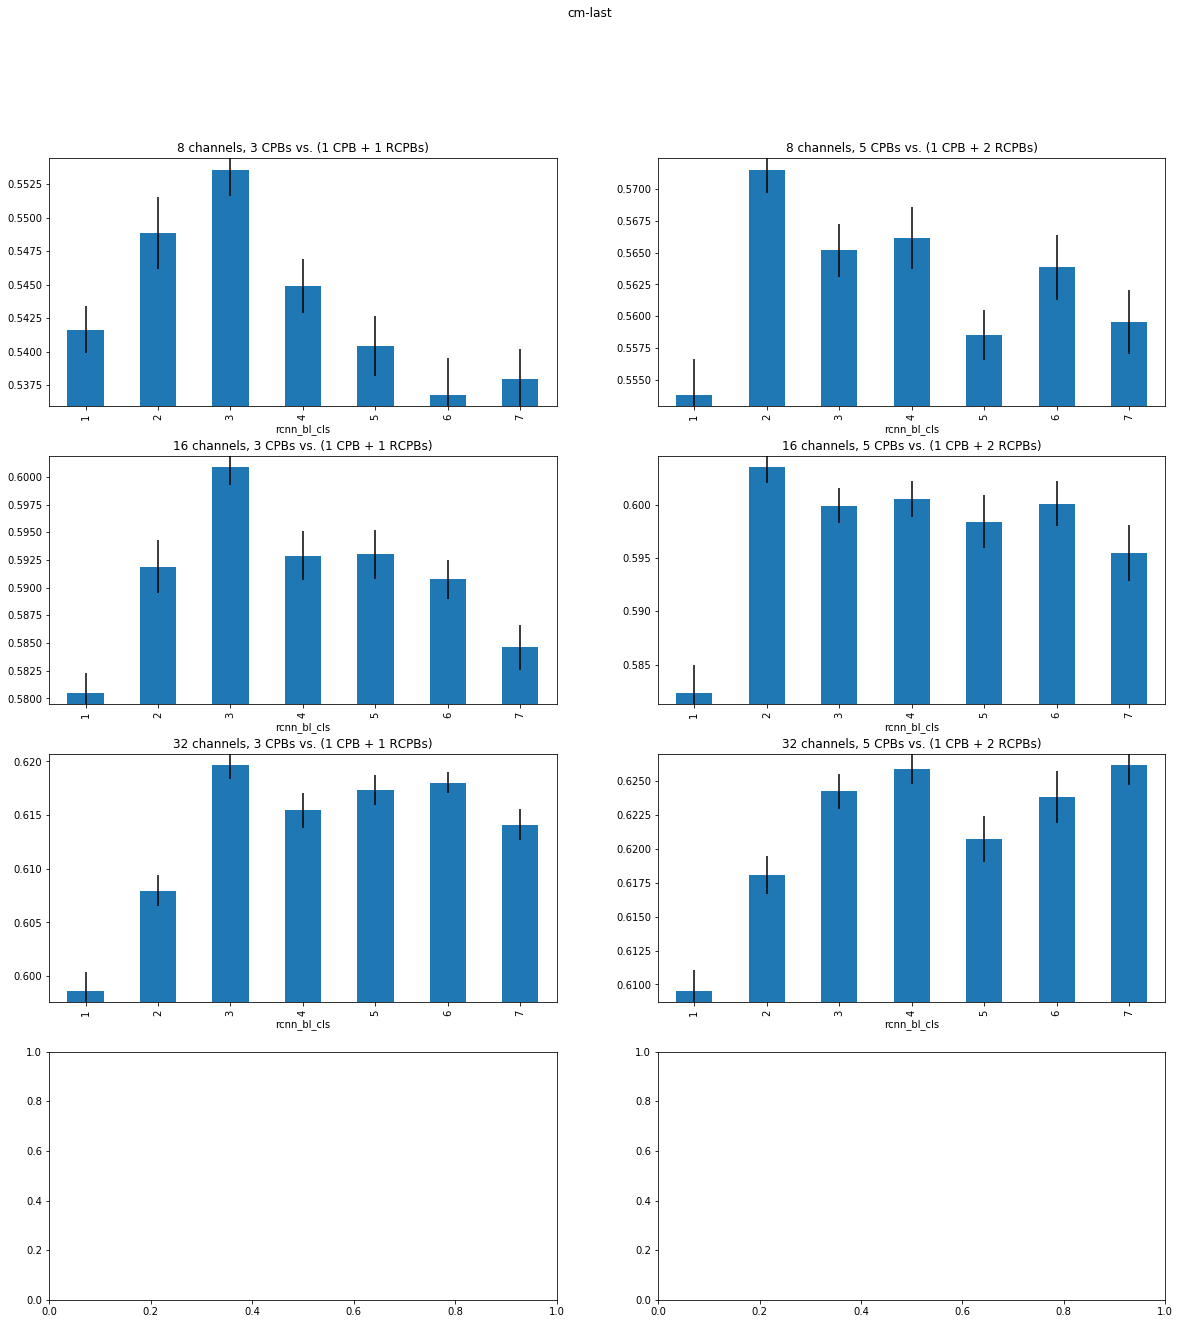

5120
(1872, 2)
seed=0, mean 0.6228860885579299 std 0.05036306109376452
seed=1, mean 0.6232243412511457 std 0.04965877178387135
corr 0.9728035007776558
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


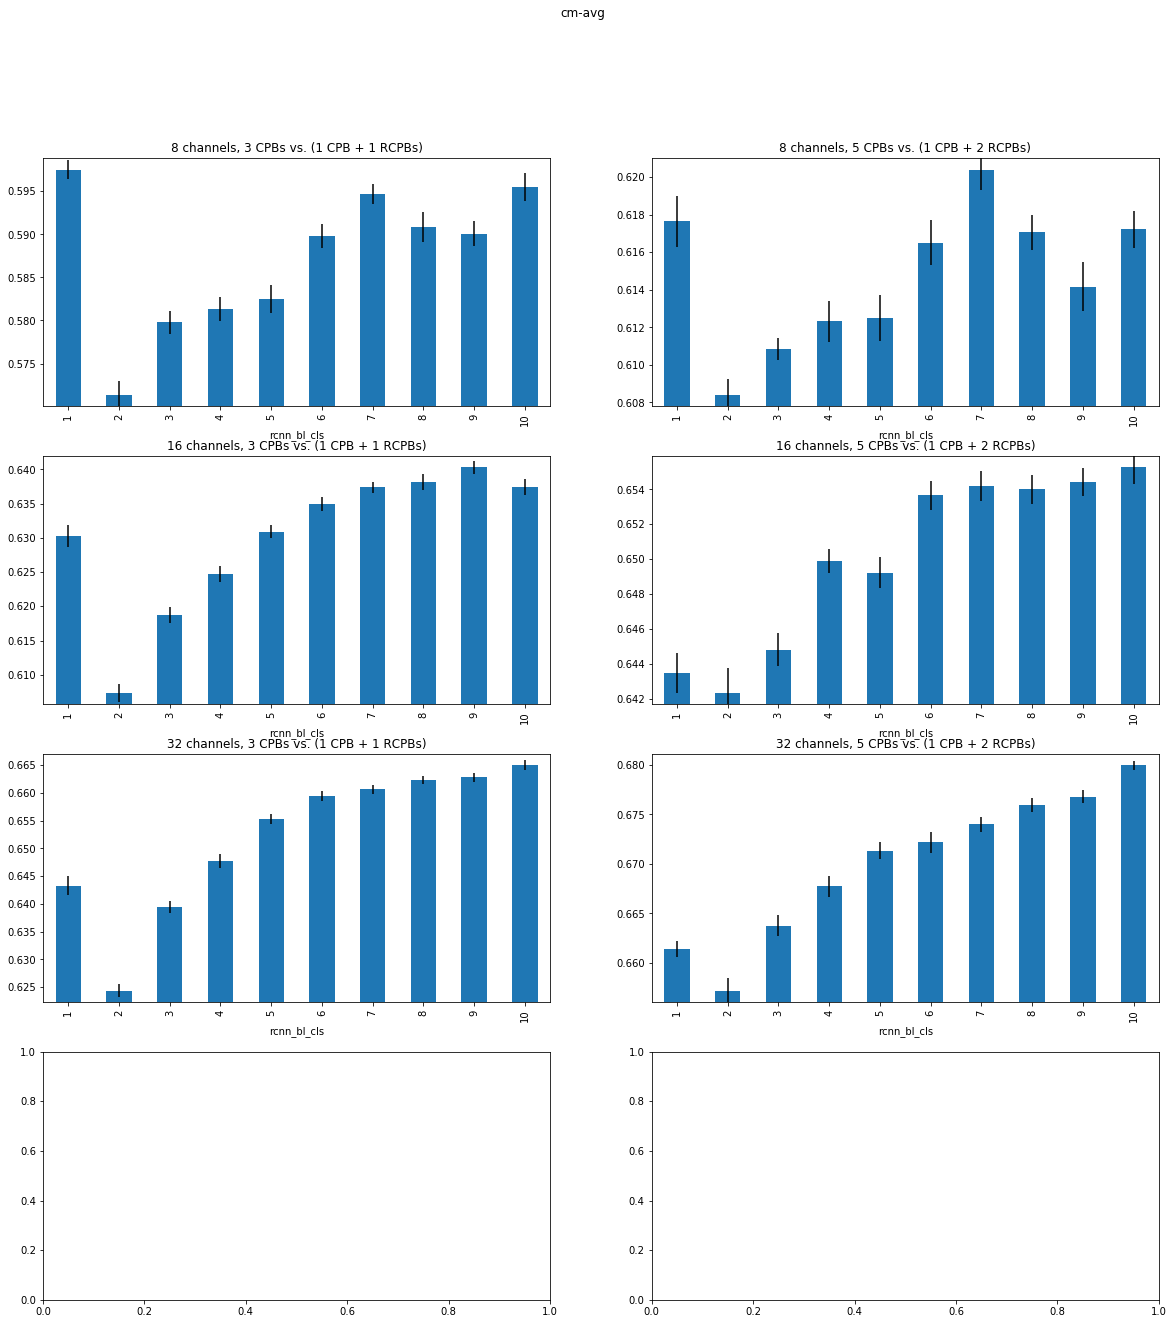

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


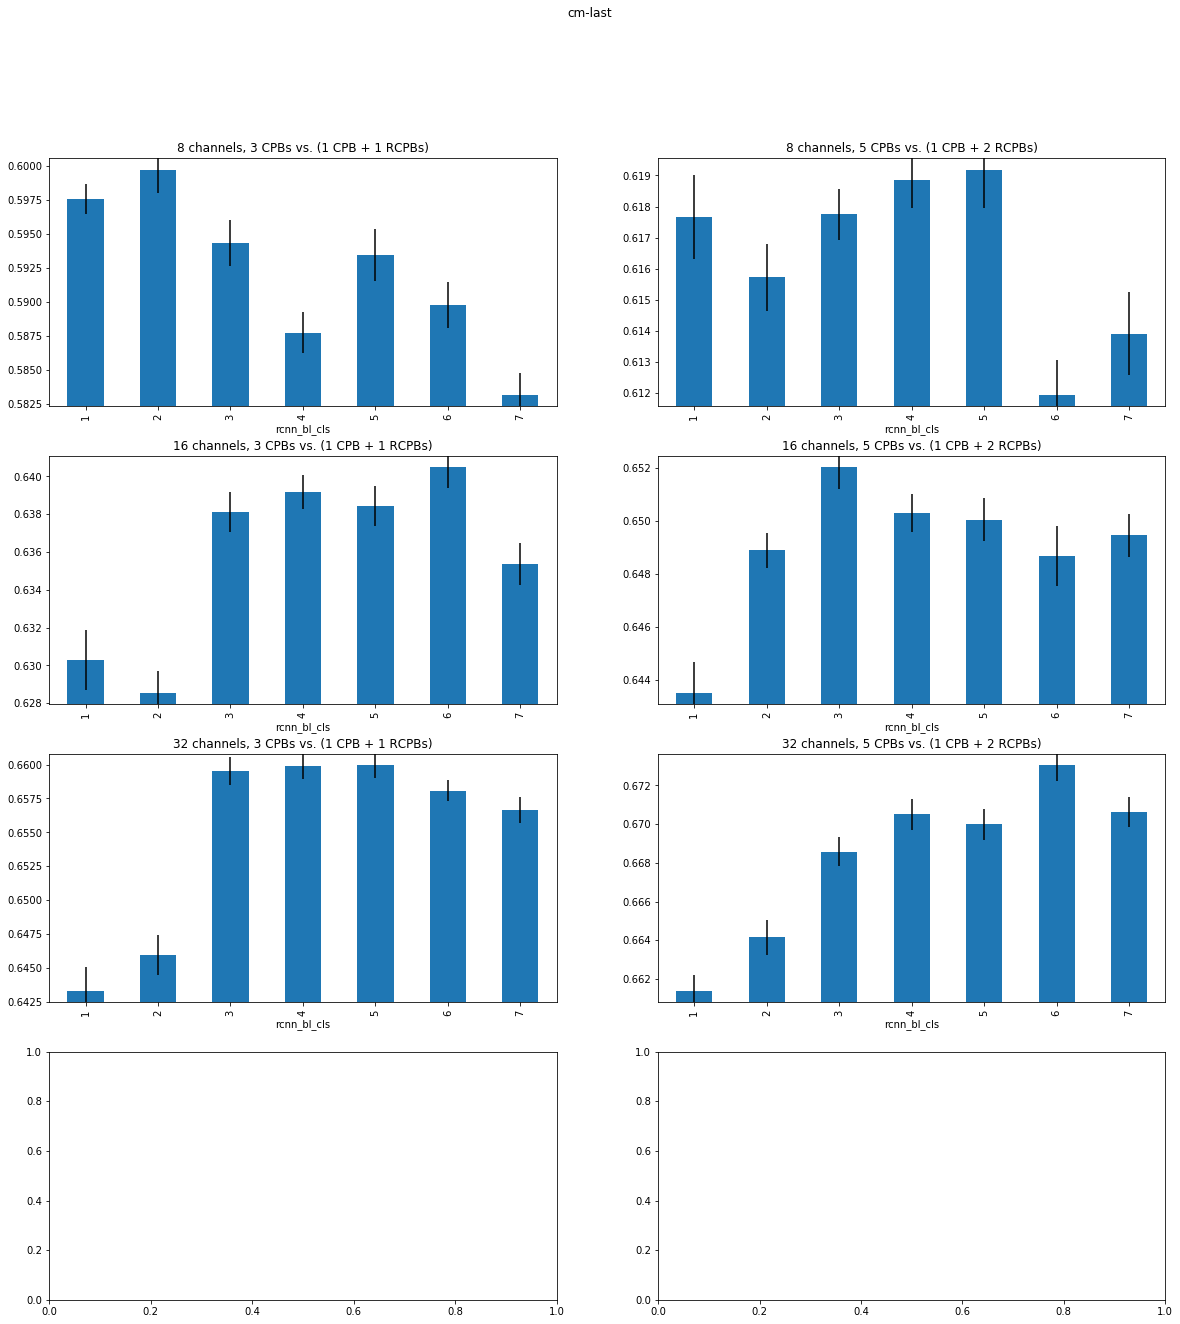

cc2_raw_avg
1280
(1872, 2)
seed=0, mean 0.21865107319578148 std 0.03666520036261439
seed=1, mean 0.21959379413632496 std 0.035808231424390165
corr 0.9151980598949551
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


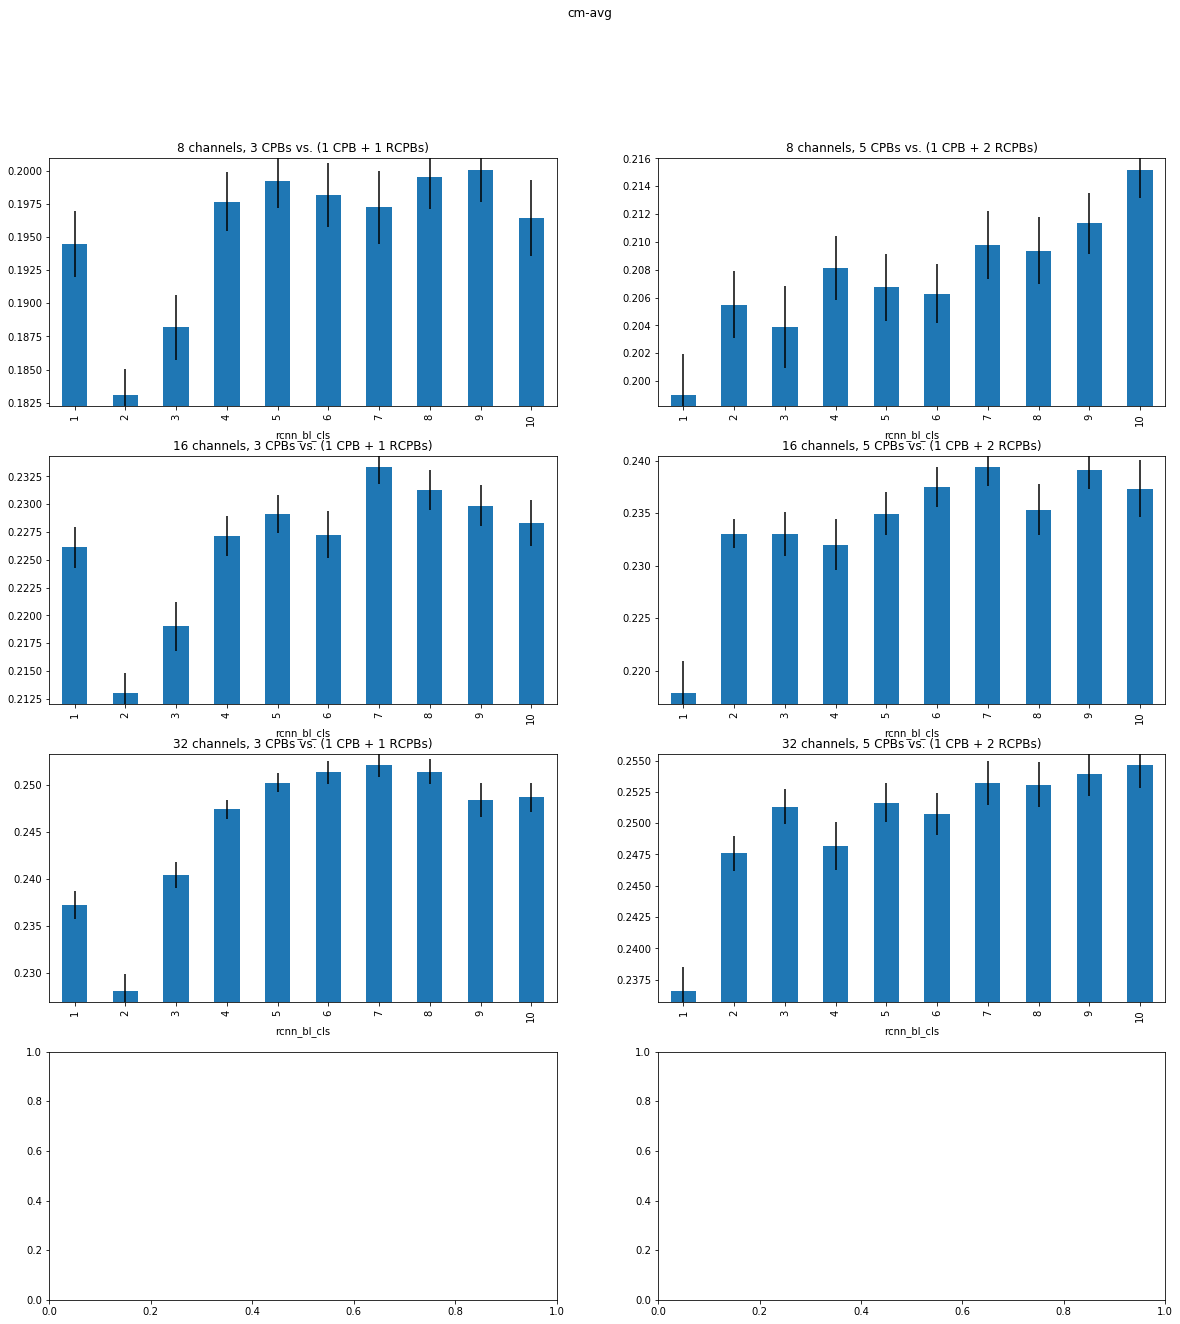

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


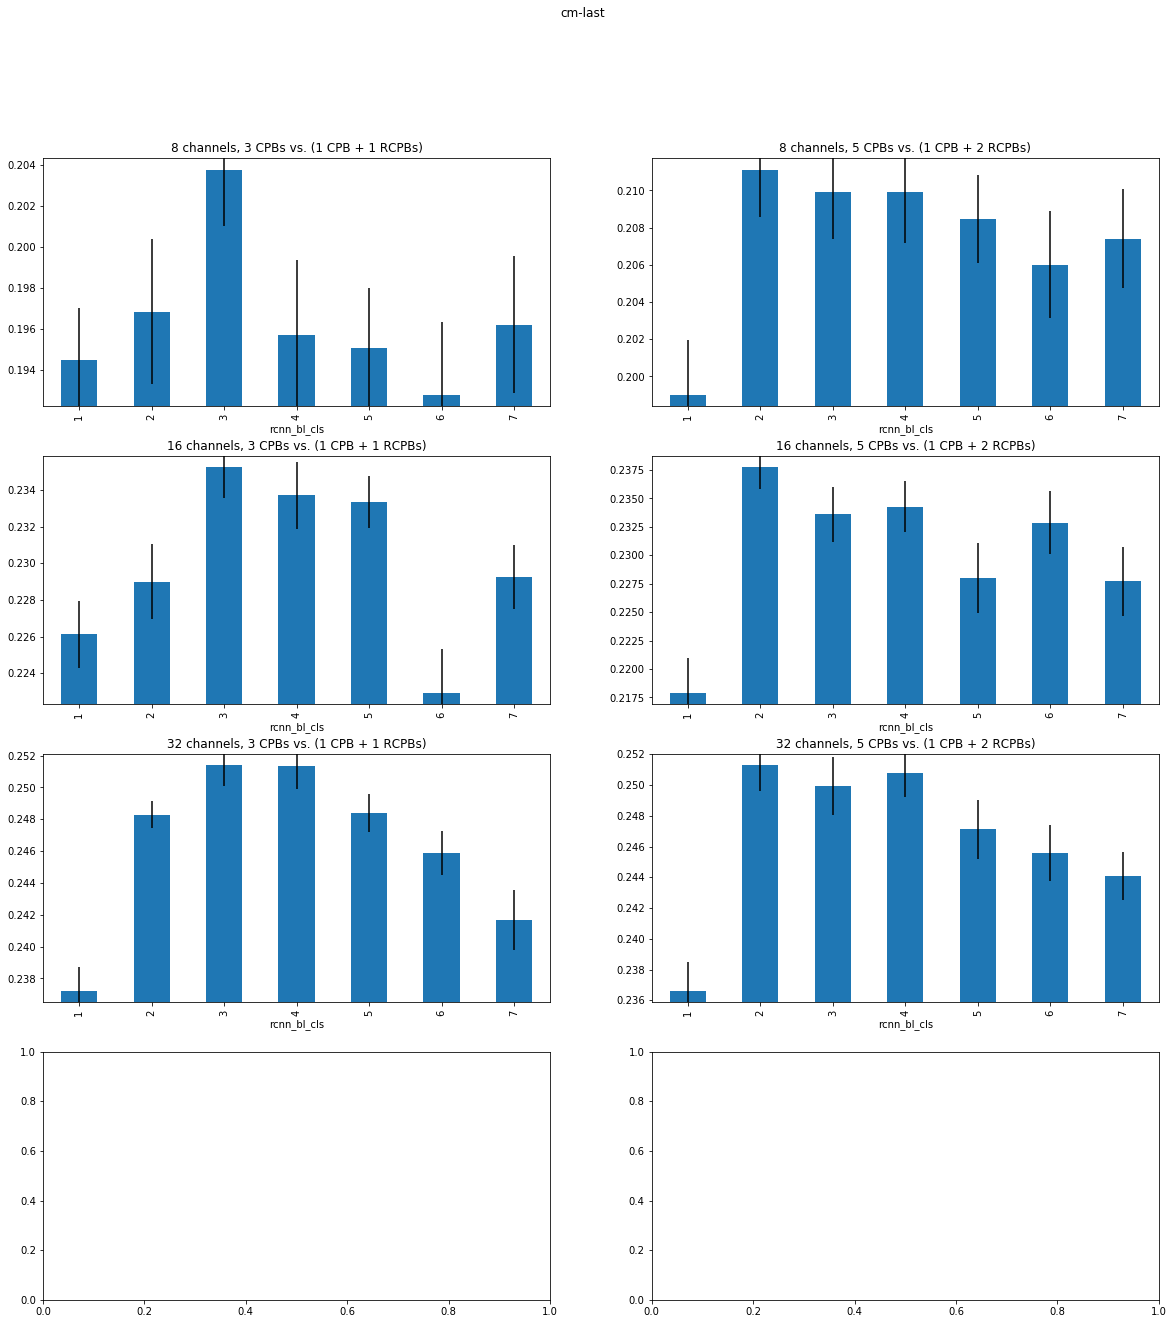

2560
(1872, 2)
seed=0, mean 0.2669831679453518 std 0.02350656934392614
seed=1, mean 0.2667768687410706 std 0.024272414062119177
corr 0.9574193669679661
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


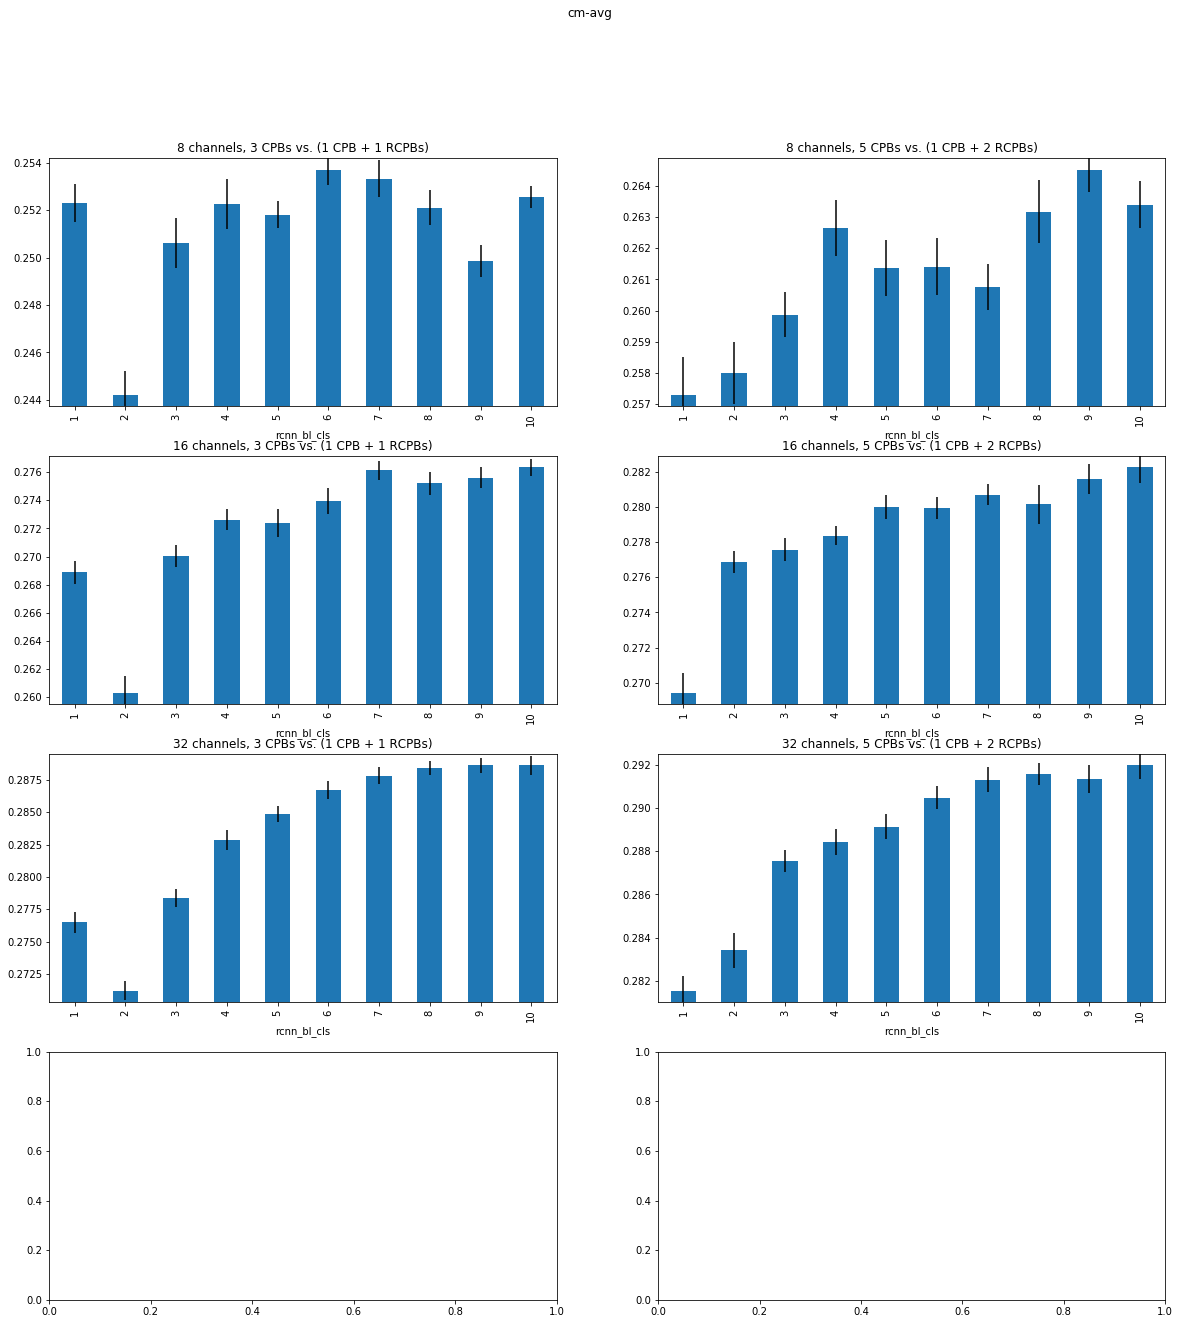

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


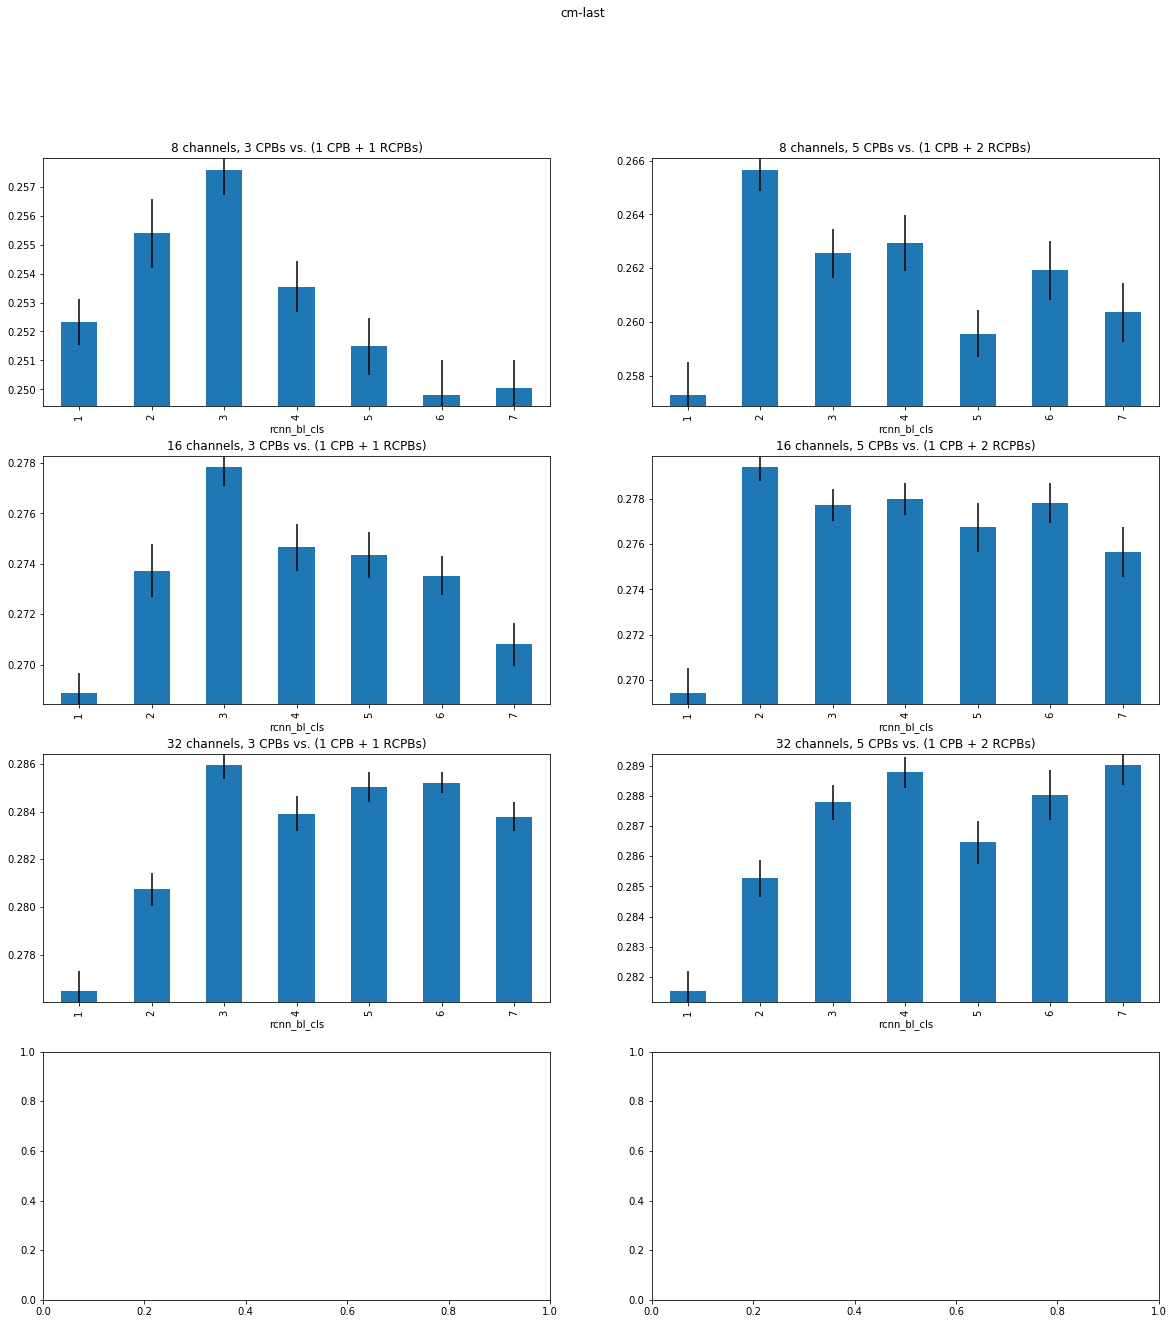

5120
(1872, 2)
seed=0, mean 0.28714448179685104 std 0.022523453200152088
seed=1, mean 0.28716860508197695 std 0.022261481371268762
corr 0.9735860945810767
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


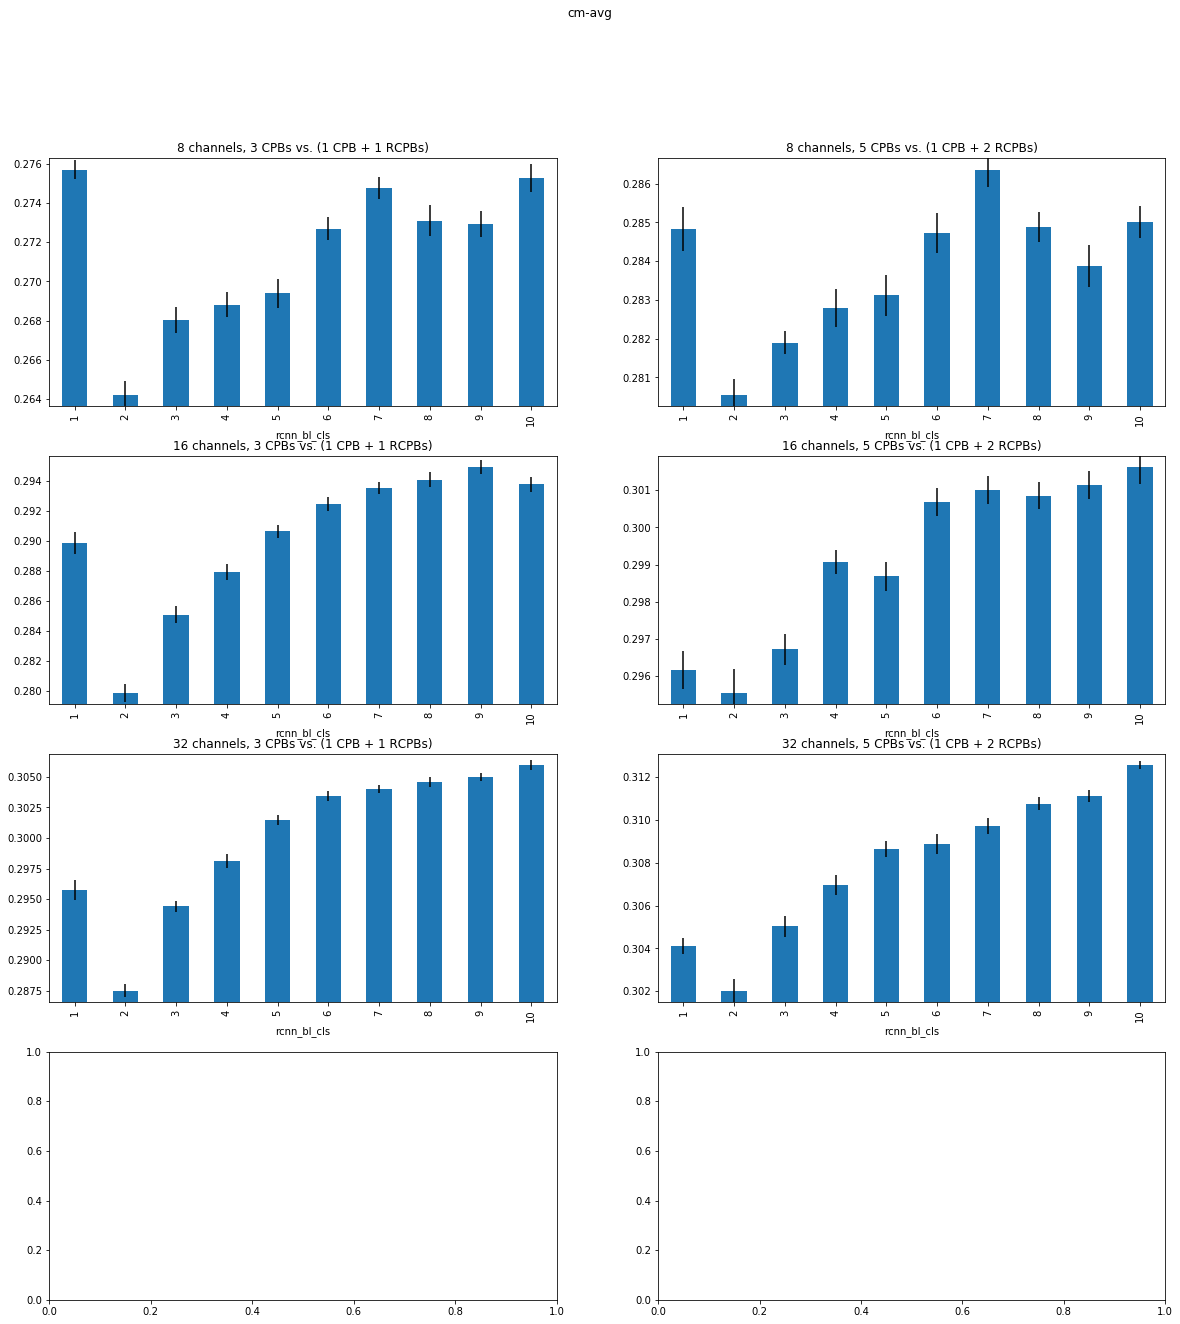

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


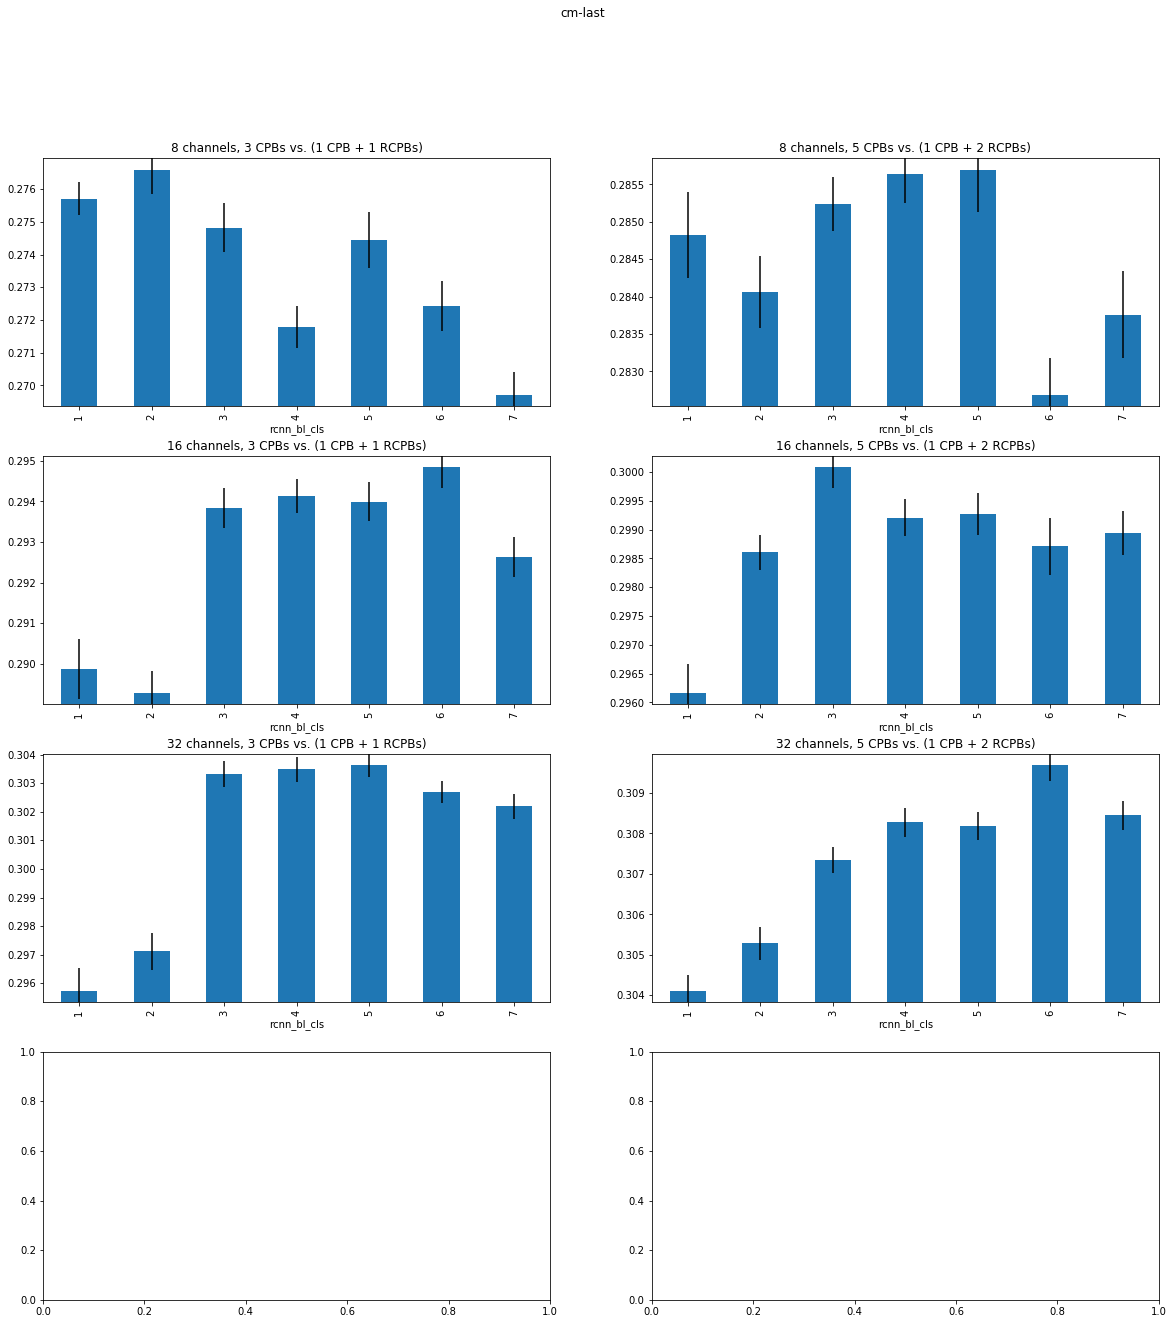

cc_raw_avg
1280
(1872, 2)
seed=0, mean 0.43978997905296374 std 0.04739777507927533
seed=1, mean 0.4412822834267545 std 0.04536985524743396
corr 0.9082938478661484
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


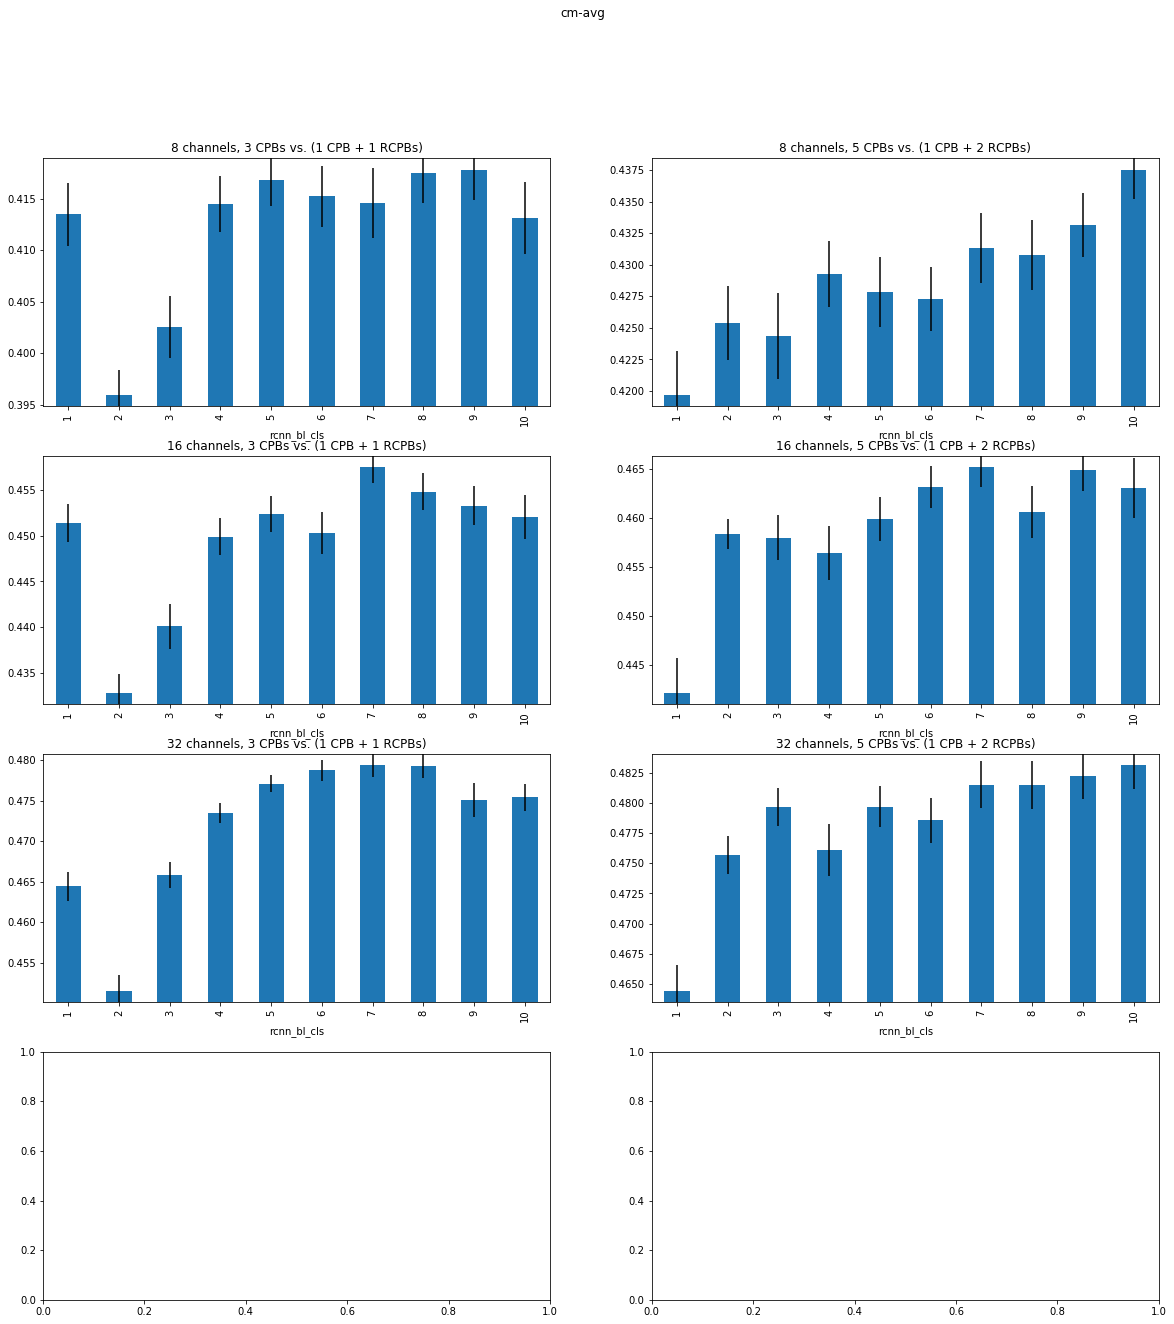

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


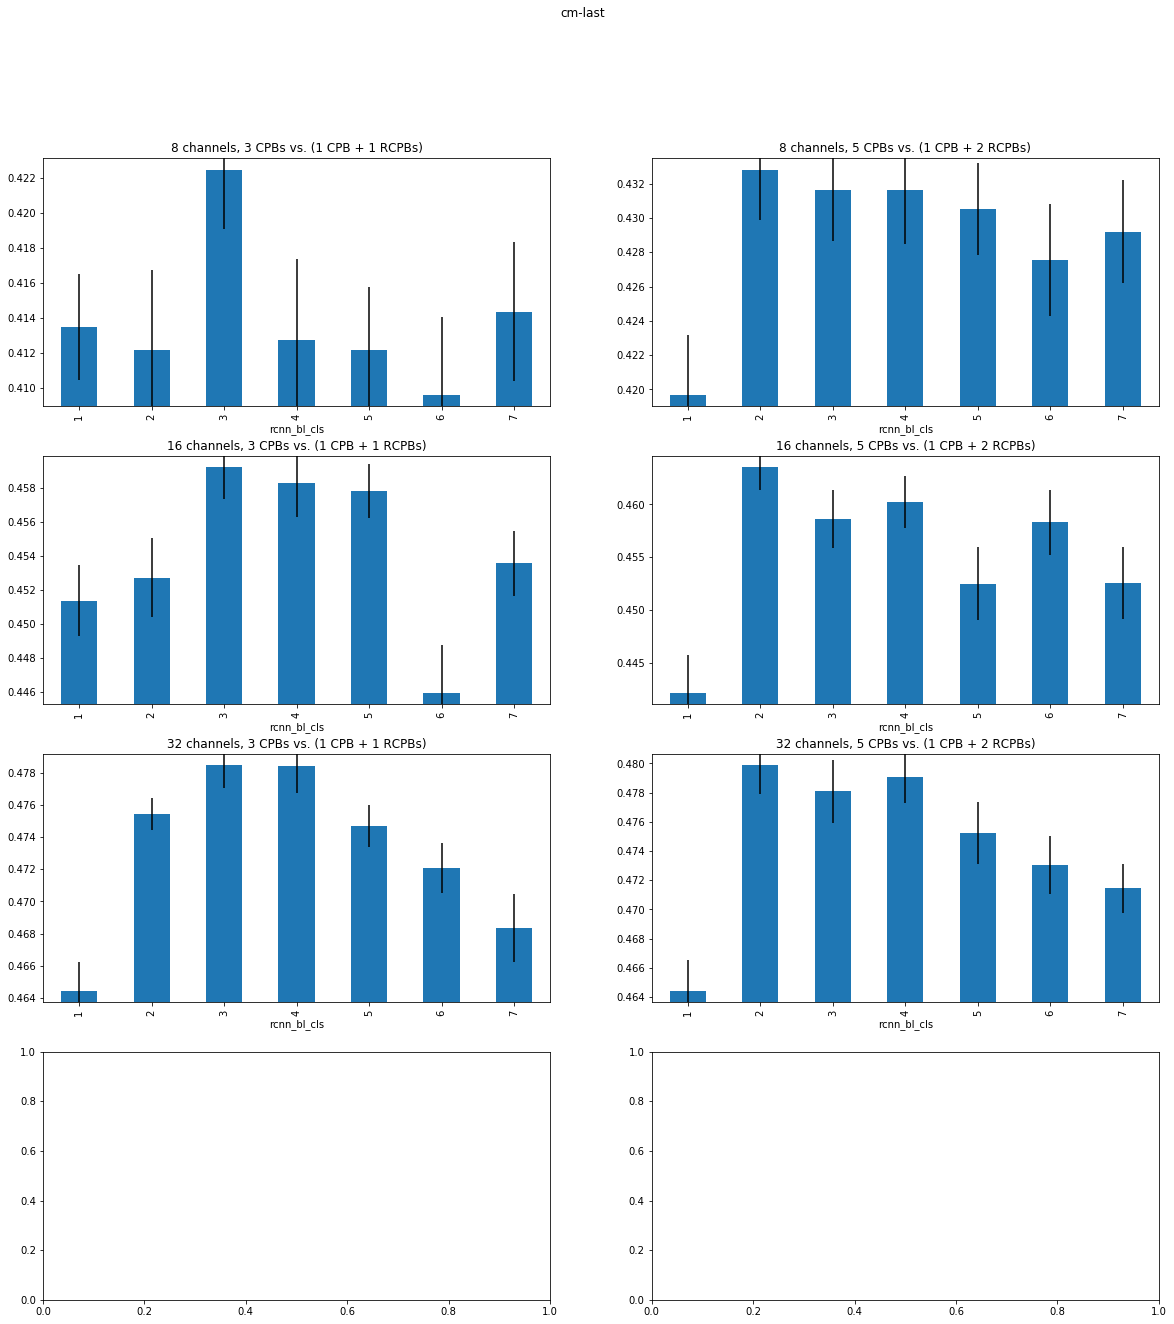

2560
(1872, 2)
seed=0, mean 0.49550092304925014 std 0.026242468107010752
seed=1, mean 0.495347617416088 std 0.02731140627714583
corr 0.9559274584493742
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


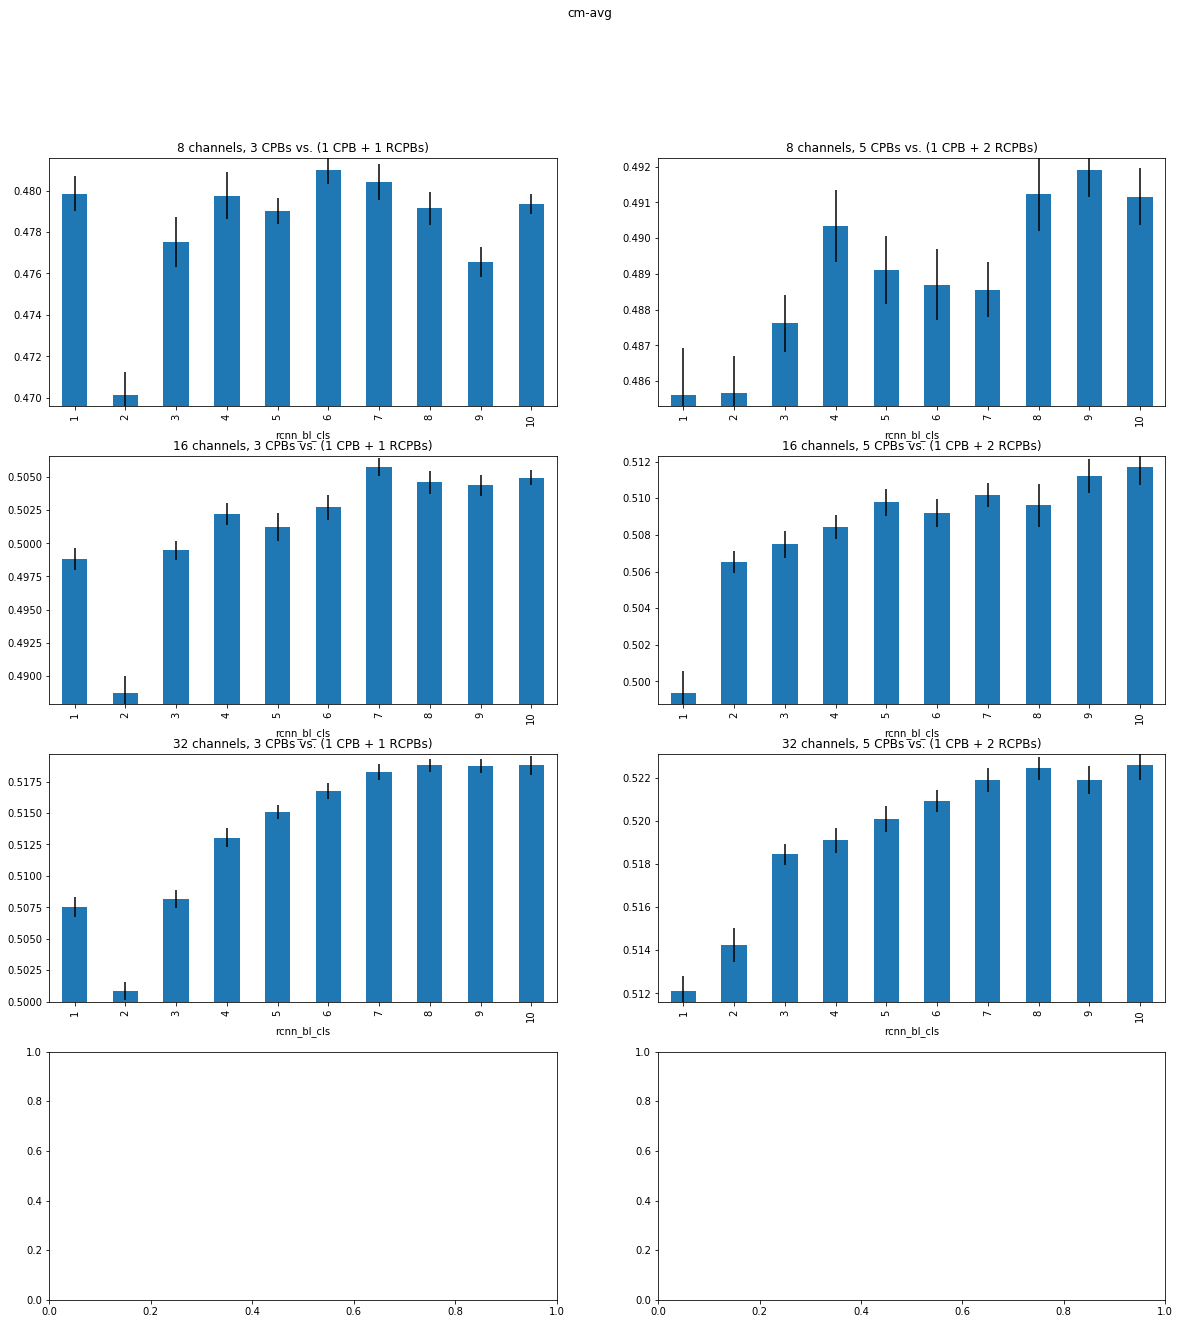

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


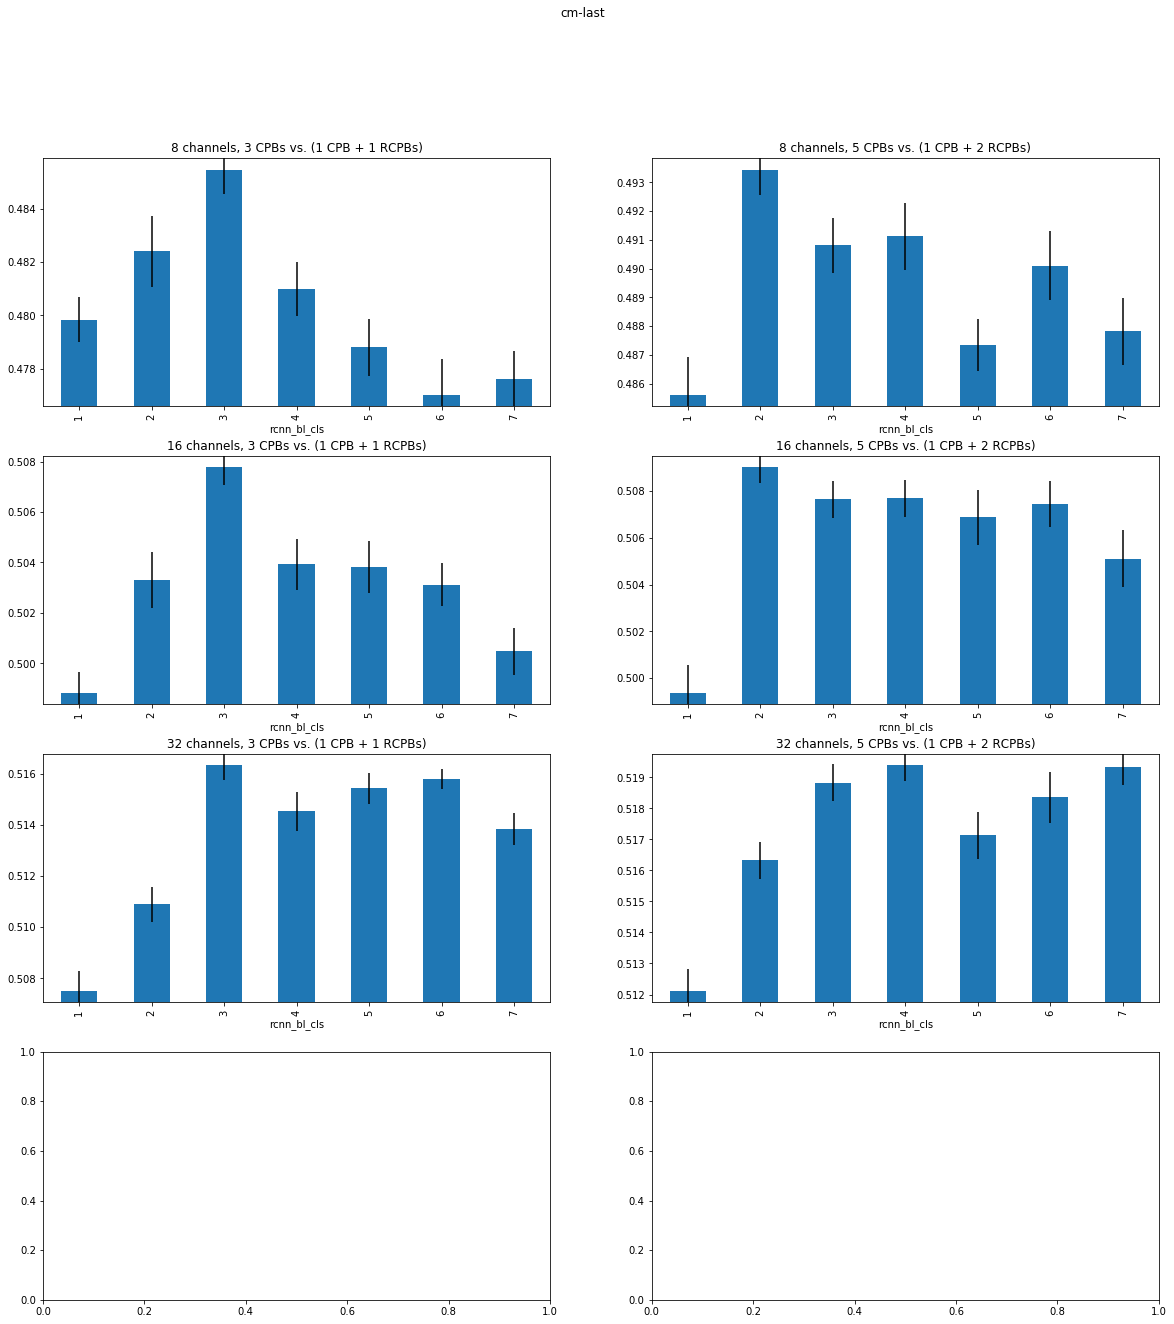

5120
(1872, 2)
seed=0, mean 0.5176152151899216 std 0.024141149845585994
seed=1, mean 0.5178355298408424 std 0.023835008348372096
corr 0.9725367697250945
(936, 2)
(432, 2)
(288, 2)


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0,18145.0,18161.0,18177.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0,19425.0,19457.0,19489.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0,23029.0,23061.0,23093.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0,27893.0,27957.0,28021.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0,39709.0,39773.0,39837.0


rcnn_bl_cls,1,2,3,4,5,6,7,8,9,10
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0,58653.0,58781.0,58909.0


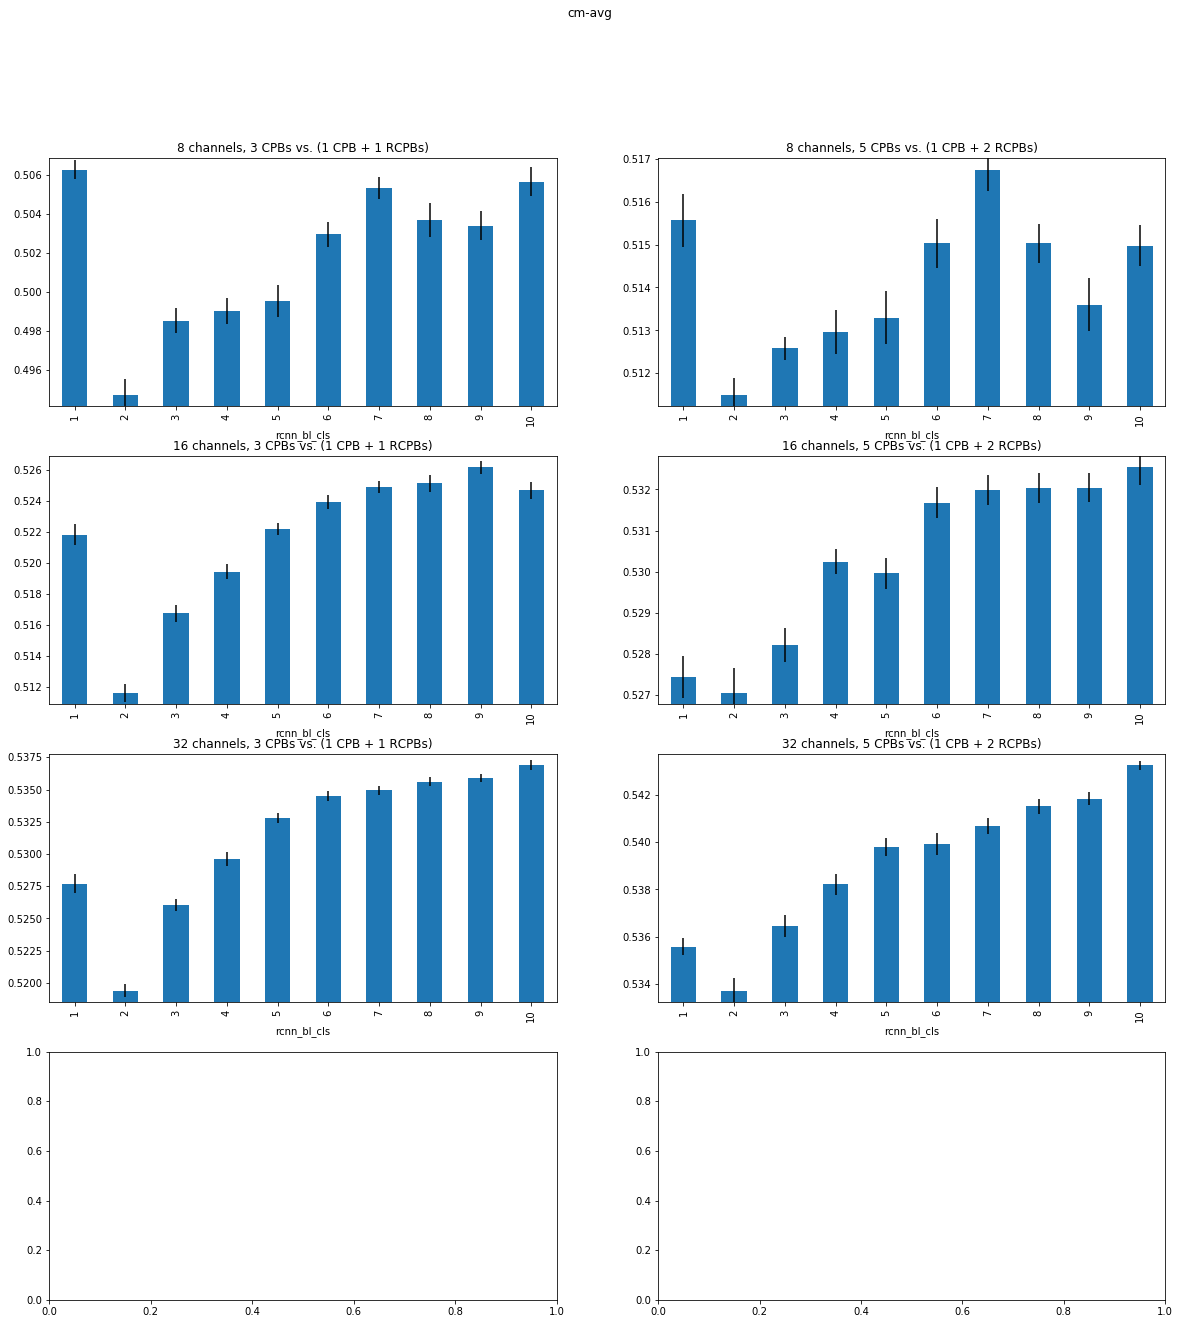

rcnn_bl_cls,1,2,3,4,5,6,7
0,18049.0,18049.0,18065.0,18081.0,18097.0,18113.0,18129.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,19233.0,19233.0,19265.0,19297.0,19329.0,19361.0,19393.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,22837.0,22837.0,22869.0,22901.0,22933.0,22965.0,22997.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,27509.0,27509.0,27573.0,27637.0,27701.0,27765.0,27829.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,39325.0,39325.0,39389.0,39453.0,39517.0,39581.0,39645.0


rcnn_bl_cls,1,2,3,4,5,6,7
0,57885.0,57885.0,58013.0,58141.0,58269.0,58397.0,58525.0


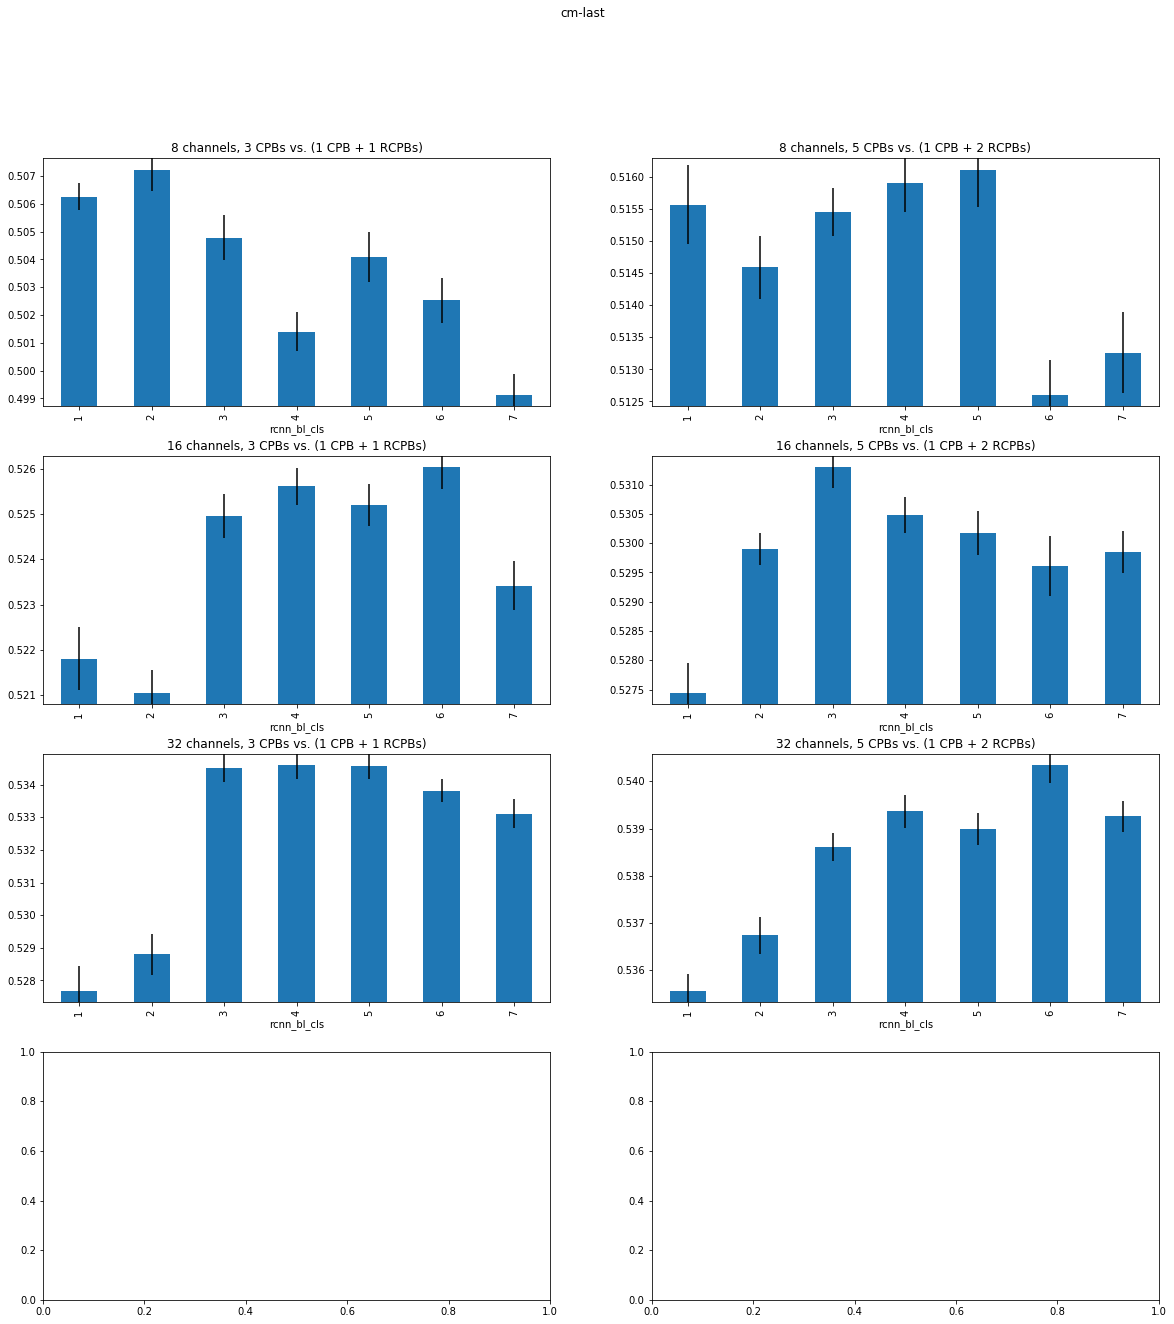

In [9]:
main_loop(df_main_result)